# Frozen Lake

In [1]:
import pandas as pd
import numpy as np
import gym
import time
from functions import *
import matplotlib.pyplot as plt

#### Actions
The agent takes a 1-element vector for actions.
<br>The action space is `(dir)`, where `dir` decides direction to move in which can be:
* 0: LEFT
* 1: DOWN
* 2: RIGHT
* 3: UP

#### Observations
4x4: 
* S F F F
* F H F H
* F F F H
* H F F G 
<br>

The observation is a value representing the agent's current position as current_row * nrows + current_col (where both the row and col start at 0).

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
<br>The number of possible observations is dependent on the size of the map.
<br>For example, the 4x4 map has 16 possible observations.

#### Rewards
Reward schedule:
* Reach goal(G): +1
* Reach hole(H): 0
* Reach frozen(F): 0

In [2]:
env = gym.make('FrozenLake-v1')

$$ P[s|a] = P[s'], s', r, \text{done} $$
$$ P[s|a] = T(s, a, s'), s', r, \text{done}$$

In [3]:
T = env.P

In [4]:
nS = env.observation_space.n
nA = env.action_space.n

Value iteration converged
policy converged at iteration 31
Wall time: 3.27 s


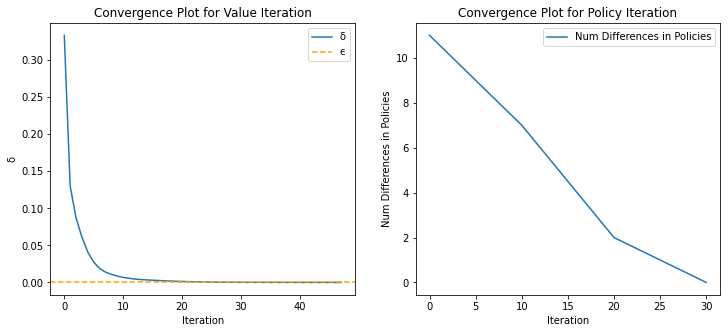

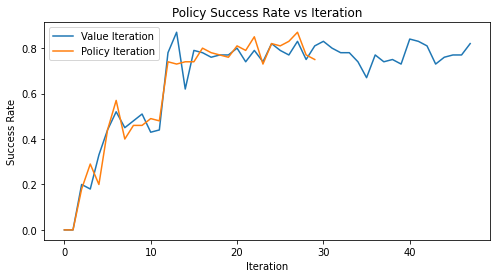

In [5]:
%%time
fig1, ax_conv = plt.subplots(1, 2, figsize=(12,5))
fig2, ax_succ = plt.subplots(figsize=(8,4))
γ, ϵ = .9, 0.00001
V, π, action, vi_runtime = value_iteration(T, γ, ϵ, ax_conv[0], ax_succ, nS, nA)

opt_V2, opt_policy2, pi_runtime = policy_iteration(T, ϵ, ax_conv[1], ax_succ, nS, nA, discount_factor = γ, max_iteration = 1000)

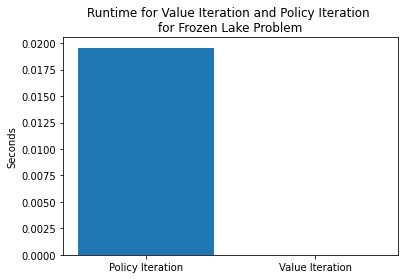

In [6]:
def plot_runtime(runtimes, labels, title):
    plt.bar(labels, runtimes)
    plt.title(title)
    plt.ylabel('Seconds')
    
plot_runtime([vi_runtime, pi_runtime], 
             ['Policy Iteration', 'Value Iteration'], 
             'Runtime for Value Iteration and Policy Iteration \nfor Frozen Lake Problem')

In [7]:
# action mapping for display the final result
action_mapping = {
    3: '\u2191', # UP
    2: '\u2192', # RIGHT
    1: '\u2193', # DOWN
    0: '\u2190' # LEFT
}

In [8]:
vi_π = [list(val).index(1) for val in π]
pi_π = list(opt_policy2)

In [9]:
print('Value Iteration Optimal Policy  :', ' '.join([action_mapping[(action)] for action in vi_π]))
print('Policy Iteration Optimal Policy :', ' '.join([action_mapping[(action)] for action in pi_π]))

Value Iteration Optimal Policy  : ← ↑ ← ↑ ← ← ← ← ↑ ↓ ← ← ← → ↓ ←
Policy Iteration Optimal Policy : ← ↑ ← ↑ ← ← ← ← ↑ ↓ ← ← ← → ↓ ←


## Q-Learning

In [12]:
def categorical_sample(prob_n):
    """Sample from categorical distribution where each row specifies class probabilities."""
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return np.argmax(csprob_n > np.random.random())

def step(T, s, a):
    transitions = T[s][a]
    i = categorical_sample([t[0] for t in transitions])
    p, s, r, t = transitions[i]
    self.lastaction = a

    if self.render_mode == "human":
        self.render()
    return (int(s), r, t, False, {"prob": p})

In [14]:
#STEP 1 - Initializing the Q-table

Q = np.zeros((env.observation_space.n, env.action_space.n))

In [10]:
#Setting the hyperparameters
              
alpha = 0.1 #learning rate                 
discount_factor = 0.3             
epsilon = 1                  
max_epsilon = 1
min_epsilon = 0.001         
decay = 0.001         

train_episodes = 10000    
test_episodes = 1000          
max_steps = 100 

In [26]:
import random
from IPython.display import clear_output


In [55]:
def qlearning(env, alpha, discount_factor, epsilon, max_epsilon, min_epsilon, decay, train_episodes ,alpha_decay):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    training_rewards = []  
    epsilons = []
    steps = []
    success_rate = []
    for episode in range(train_episodes):
        state = env.reset()[0]    
        total_training_rewards = 0

        for step in range(1000):
            exp_exp_tradeoff = random.uniform(0, 1) 
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(Q[state,:])      
            else:
                action = env.action_space.sample()
            new_state, reward, done, info, _ = env.step(action)
            Q[state, action] = (Q[state, action] + 
                                alpha * (reward + 
                                         discount_factor * np.max(Q[new_state, :]) - 
                                         Q[state, action])) 
            total_training_rewards += reward      
            state = new_state         
            if done == True:
                break
        q_policy = [np.argmax(val) for val in Q]
        success_rate.append(test_frozen_lake_policy(q_policy))
        print(f'\rEpisode: {episode} \tSuccess Rate: {np.max(success_rate)}', end='\r')
        steps.append(step)
        alpha = .001 + alpha * alpha_decay
        if epsilon > min_epsilon:
            epsilon = epsilon * decay
        else: epsilon = min_epsilon
        training_rewards.append(total_training_rewards)
        epsilons.append(epsilon)
    return Q, sum(training_rewards)/train_episodes, steps[-1], success_rate

In [ ]:
alpha = 0.1 #learning rate      
train_episodes = 1000 
discount_factor = 0.3             
epsilon = 1                  
max_epsilon = 1
min_epsilon = 0.001         
decay = 0.001   
qs = []
res = []
for alpha in [0.1,.2, .3]:
    for discount_factor in [.4, .6, .8, .9]:
        for min_epsilon in [0.001]:
            for decay in [0.7, .8, .9, .99]:
                for alpha_decay in [0.7, 0.8, 0.9,.99]:
                    clear_output(wait=True)
                    print('alpha:', alpha)
                    print('discount_factor:', discount_factor)
                    print('epsilon decay:', decay)
                    print('alpha decay:', alpha_decay)
                    start = time.time()
                    q, rew, steps, success_rate = qlearning(
                        env, 
                        alpha, 
                        discount_factor, 
                        epsilon, 
                        max_epsilon, 
                        min_epsilon, 
                        decay, 
                        train_episodes, 
                        alpha_decay
                    )
                    end = time.time()
                    qs.append(q)
                    q_policy = [np.argmax(val) for val in q]
                    res.append({
                        'Reward':rew,
                        'Success Rate':max(success_rate),
                        'Steps':steps,
                        'Time': end-start,
                        'alpha':alpha, 
                        'alpha_decay':alpha_decay,
                        'discount_factor':discount_factor, 
                        'min_epsilon':min_epsilon, 
                        'epsilon_decay':decay,

                    })
res_df = pd.DataFrame(res)

alpha: 0.3
discount_factor: 0.4
epsilon decay: 0.8
alpha decay: 0.7
Episode: 951 	Success Rate: 0.0

In [102]:
res_df.sort_values('Reward').iloc[-1]

Reward              0.214200
Success Rate        0.240000
Steps              54.000000
Time                4.755826
alpha               0.010000
alpha_decay         0.900000
discount_factor     0.200000
min_epsilon         0.001000
epsilon_decay       0.010000
Name: 57, dtype: float64

In [ ]:
def plot_q(q_df, param, param2, metric):
    copy = q_df.copy()# .groupby(param).mean()
    for val in copy[param2].unique():
        cur = copy[copy[param2] == val]
        grouped = cur.groupby(param).mean()
        plt.plot(grouped.index, grouped[metric])
        plt.scatter(cur[param], cur[metric], label=f'{param2}:{val}', alpha=0.6)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel(metric)
    plt.title(f'{param}, {param2} vs {metric}')
    
plot_q(res_df, 'alpha', 'alpha_decay', 'Success Rate')